# Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = '/content/drive/My Drive/Colab Notebooks/predict_future_sales/data/prep/'
sub_path = '/content/drive/My Drive/Colab Notebooks/predict_future_sales/submissions/'
model_path = '/content/drive/My Drive/Colab Notebooks/predict_future_sales/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Install libs

In [3]:
!pip install catboost

     |████████████████████████████████| 62.5MB 764kB/s 


# Import libs

In [4]:
import pandas as pd
import numpy as np
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import datetime
from pytz import timezone
import time
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from catboost import *
from sklearn import linear_model
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

index_cols = ['shop_id', 'item_id', 'date_block_num'] 
cols_to_drop = ['target', 'date_block_num']

1.14.0


# Load Data

In [0]:
grid = pd.read_pickle(data_path + 'grid_No_missing_06_57_56__15_Sep_2019.pkl')

# Utile Functions

In [3]:
def train_val_test_split(df):
    dates = df['date_block_num']
    last_block = dates.max()
    print('Test `date_block_num` is %d' % last_block)
    print('Validation `date_block_num` is %d' % (last_block - 1))
    print('Train `date_block_num` is < %d' % (last_block - 1))
    print('------------------------------')

    X_train = df.loc[dates < last_block - 1].drop(cols_to_drop, axis = 1)
    X_val = df.loc[dates == last_block - 1].drop(cols_to_drop, axis = 1)
    X_test =  df.loc[dates == last_block].drop(cols_to_drop, axis = 1)

    y_train = df.loc[dates < last_block - 1, 'target'].values
    y_val =  df.loc[dates == last_block - 1, 'target'].values
    y_test = df.loc[dates == last_block, 'target'].values
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    print('------------------------------')
    print('X_val shape: ', X_val.shape)
    print('y_val shape: ', y_val.shape)
    print('------------------------------')
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', y_test.shape)
    print('------------------------------')
    return (X_train, y_train, X_val, y_val, X_test, y_test)

def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

def create_submission(model, X, model_name = 'lgb'):
    y_hat = model.predict(X).clip(0, 20)
    submission = pd.DataFrame(columns = ['ID', 'item_cnt_month'])
    test = pd.read_pickle(data_path + 'test.pkl')
    submission.ID = test.index.values
    submission.item_cnt_month = y_hat
    now = datetime.datetime.now(timezone('Europe/Berlin'))
    file_id = now.strftime("%H_%M_%S__%d_%h_%Y")
    file_save_path = sub_path + model_name + '_' + file_id + '.csv'
    submission.to_csv(file_save_path, index = False)
    print('saved: ', file_save_path)
    submission_name = model_name + '_' + file_id 
    return (submission, submission_name)
  
def create_model(X_train, y_train, X_val, y_val, params, categorical_features):
    n_estimators = 8000
    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_val, y_val)
    watchlist = [d_train, d_valid]
    evals_result = {}
    model = lgb.train(params, 
                      d_train, 
                      n_estimators,
                      valid_sets = watchlist, 
                      evals_result = evals_result, 
                      early_stopping_rounds = 50,
                      verbose_eval = 0,
                      categorical_feature = categorical_features,
                    )
    lgb.plot_metric(evals_result)
    return model

def submit_solution(submission, submission_name, hack_submission = True):
    if hack_submission == True:
        outdated_items = pd.read_pickle(data_path + 'outdated_items.pkl')
        outdated_shops = pd.read_pickle(data_path + 'outdated_shops.pkl')
        outdated_categories = pd.read_pickle(data_path + 'outdated_categories.pkl')
        test = pd.read_pickle(data_path + 'test.pkl')
        test = test.reset_index()

    test_outdated_items_ids = test.loc[test.item_id.isin(outdated_items.item_id.unique())].ID.values
    test_outdated_shops_ids = test.loc[test.shop_id.isin(outdated_shops.shop_id.unique())].ID.values
    submission.loc[submission.ID.isin(test_outdated_items_ids), 'item_cnt_month'] = 0
    submission.loc[submission.ID.isin(test_outdated_shops_ids), 'item_cnt_month'] = 0

    import json
    access_token = {"username":"basselkassem","key":"d40e51c9ae7e205ee362a3f2e9ae25b1"}
    with open('/content/kaggle.json', 'w') as file:
        json.dump(access_token, file)
    !pip install -q kaggle
    !mkdir -p ~/.kaggle 
    !cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    submission.to_csv(submission_name + '.csv', index = 0)
    !kaggle competitions submit -c competitive-data-science-predict-future-sales -f {submission_name}.csv -m "Message"

def evaluate_model(model, X_train, y_train, X_val, y_val): 
    y_hat = model.predict(X_train)
    print('Training error;', rmse(y_train, y_hat))
    y_val_hat = model.predict(X_val)
    print('Validation error:', rmse(y_val, y_val_hat))
    
def plot_feature_importance(model, X):
    feat_importance = pd.DataFrame(sorted(zip(model.feature_importance(importance_type = 'gain'), X.columns)), columns=['Score','Feature'])
    feat_importance = feat_importance.sort_values(by = "Score", ascending = False)
    plt.figure(figsize = (10, 15))
    sns.barplot(x = "Score", y = "Feature", data = feat_importance)
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
    return feat_importance.reset_index(drop = True)

def plot_catboost_feature_importance(model, X, y):
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(
        Pool(X, label = y, cat_features = categorical_features_index)))), columns=['Feature','Score']
        )

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    plt.rcParams["figure.figsize"] = (15, 7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()
    return feature_score

def plot_correlation(corr):
    f, ax = plt.subplots(figsize = (18, 8))
    ax = sns.heatmap(corr, cmap = plt.cm.Reds)
    ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation = 45,
      horizontalalignment = 'right'
    )
    plt.show()

def generate_name(my_name):
    now = datetime.datetime.now(timezone('Europe/Berlin'))
    name_id = now.strftime("%H_%M_%S__%d_%h_%Y")
    return my_name + '_' + name_id
  
def nn_rmse(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))
def build_nn_model(input_shape):
    model = keras.Sequential([
      layers.Dense(128, kernel_initializer='uniform', activation = tf.nn.relu, input_shape = input_shape),
      layers.Dense(1, kernel_initializer='uniform')
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = [nn_rmse])
    return model

# Feature Selection

We have 87 features. We want to choose 30~32 relavent features.

Due to computing power limitation, we will choose relevant features manually. 
I will choose the features using correlation matrix and  xgbtree features importance.

## Correlation matrix

In [0]:
X = grid[grid.date_block_num < 34]
corr = X.corr()
corr.to_pickle(data_path + 'corr.pkl')

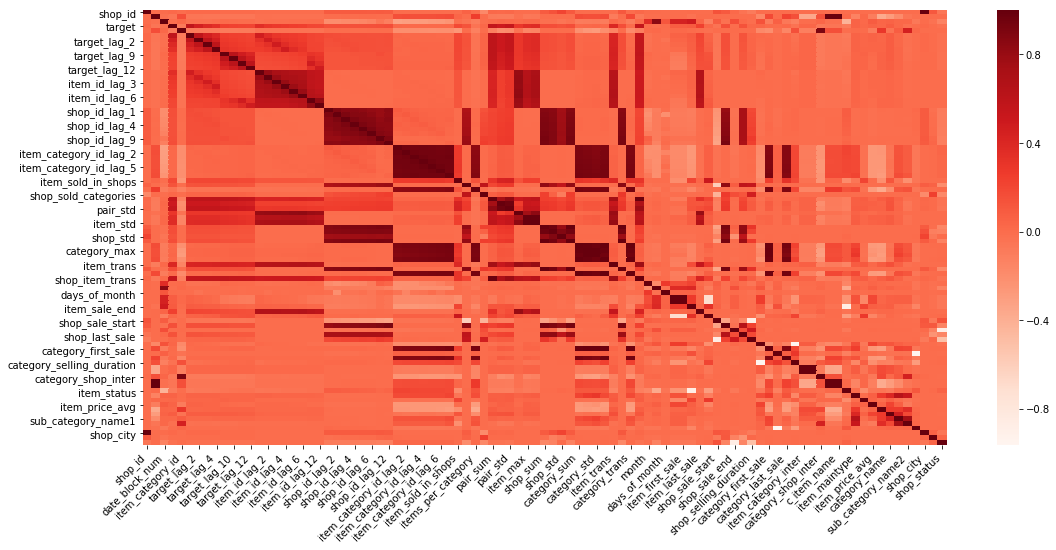

In [0]:
plot_correlation(corr)

## Feature importance

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(grid)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 91)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 91)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 91)
y_test shape:  (214200,)
------------------------------


316 seconds


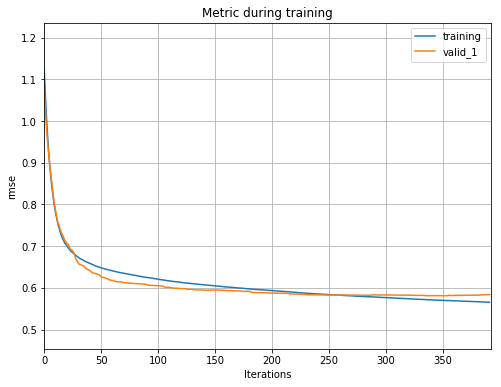

In [0]:
start = time.time()
params = {
    'metric': 'rmse',
    'objective': 'mse', 
    'verbose': 0,
}
model = create_model(X_train, y_train, X_val, y_val, params)
print(round(time.time() - start), 'seconds')

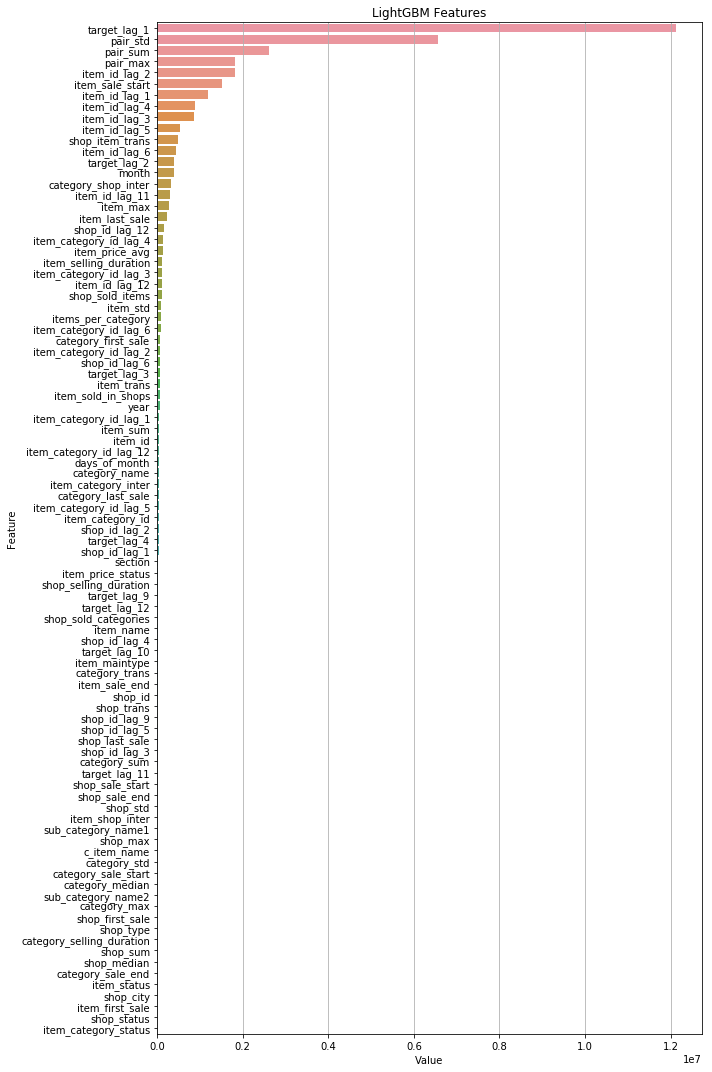

In [0]:
feature_importance = plot_feature_importance(model, X_train)

In [0]:
feature_importance.to_pickle(data_path + 'feature_importance.pkl')

## Choose features

In [0]:
features_num = 32

In [0]:
feature_importance = pd.read_pickle(data_path + 'feature_importance.pkl')
corr = pd.read_pickle(data_path + 'corr.pkl')

In [0]:
cor_target = abs(corr["target"])
corr_relevant_features = cor_target.sort_values(ascending = False).head(features_num + 1)
print(len(corr_relevant_features[1:]))
corr_relevant_features = corr_relevant_features[1:]

32


In [0]:
feature_importance_lgm = feature_importance.head(features_num)

In [0]:
corr_relevant_features_set = set(corr_relevant_features.index.values)
feature_importance_set = set(feature_importance_lgm.Feature.values)

In [0]:
relevent_features = list(feature_importance_set.intersection(corr_relevant_features_set))
len(relevent_features)

19

In [0]:
fi_not_cf = feature_importance_set - feature_importance_set.intersection(corr_relevant_features_set)
fi_not_cf

{'category_first_sale',
 'category_shop_inter',
 'item_category_id_lag_2',
 'item_category_id_lag_3',
 'item_category_id_lag_4',
 'item_category_id_lag_6',
 'item_price_avg',
 'item_sale_start',
 'item_selling_duration',
 'items_per_category',
 'month',
 'shop_id_lag_6',
 'shop_sold_items'}

In [0]:
relevent_features = relevent_features + list(fi_not_cf)[:11]
len(relevent_features)

30

In [0]:
cf_not_fi = corr_relevant_features_set - corr_relevant_features_set.intersection(feature_importance_set)
cf_not_fi

{'item_sold_in_shops',
 'item_sum',
 'item_trans',
 'shop_first_sale',
 'shop_max',
 'shop_median',
 'shop_sum',
 'shop_trans',
 'target_lag_10',
 'target_lag_11',
 'target_lag_12',
 'target_lag_4',
 'target_lag_9'}

In [0]:
relevent_features = relevent_features + list(cf_not_fi)[:2]
len(relevent_features)

32

## Test  Feature selection

In [0]:
data = grid[relevent_features + cols_to_drop]

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test  = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


In [0]:
X_test = X_test.fillna(0)

165 seconds


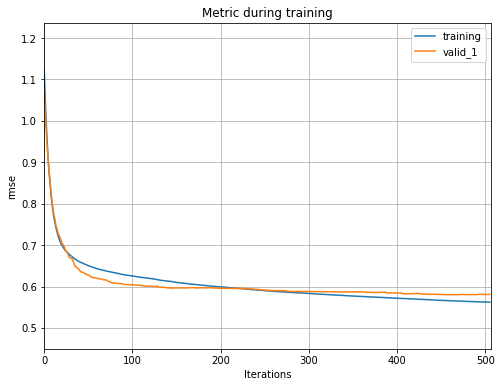

In [0]:
start = time.time()
params = {
    'metric': 'rmse',
    'objective': 'mse', 
    'verbose': 0,
}
model_lgm = create_model(X_train, y_train, X_val, y_val, params)
print(round(time.time() - start), 'seconds')

In [0]:
evaluate_model(model_lgm, X_train, y_train, X_val, y_val)

Training error; 0.5661690149280277
Validation error: 0.5802194244892465


In [0]:
submission, submission_name = create_submission(model_lgm, X_test)

saved:  /content/drive/My Drive/Colab Notebooks/predict_future_sales/submissions/lgb_18_55_02__15_Sep_2019.csv


# Selected Features

Although the features That have been chosen gave greate result on the training set and validation set but they overfit badly on the test set. 

Those features fail to provide good score because they are more specific to the pair shop/item. In the test set we have lot of pairs with no history, and new items with no history as well.

After running some experments, I found that the best feature setup is the features that describe:
- pair sales history
- item sales history
- shop sales history
- item cateory sales history

In [0]:
base_features = ['shop_id', 'item_id', 'date_block_num', 'target', 'item_category_id',
                 
                 'target_lag_1', 'target_lag_2', 'target_lag_3', 
                 'target_lag_4', 'target_lag_9', 'target_lag_10', 
                 'target_lag_11', 'target_lag_12',
                 
                 'item_id_lag_1', 'item_id_lag_2', 'item_id_lag_3', 
                 'item_id_lag_4', 'item_id_lag_5', 'item_id_lag_11', 
                 'item_id_lag_12', 
                 
                 'shop_id_lag_1', 'shop_id_lag_2', 'shop_id_lag_3', 
                 'shop_id_lag_4', 'shop_id_lag_5', 'shop_id_lag_12',

                 'item_category_id_lag_1', 'item_category_id_lag_2', 'item_category_id_lag_3', 
                 'item_category_id_lag_4', 'item_category_id_lag_5', 'item_category_id_lag_12',

                 'month', 'category_shop_inter',
                ]
                
categorical_features = ['shop_id', 'item_category_id', 'month', 'category_shop_inter']

 I will not allow catboost and lightGBM to consider **item_id** as a categorical feature because of the high cardinality of this feature (21000 items). This makes the models overfit when they try to deal with this feature. 

I will consider it as continuous feature. 

# Normalize data

In [0]:
def norm(df, all_cols = False):
    sc = StandardScaler()
    train_set = df[df['date_block_num']!= df['date_block_num'].max()].reset_index(drop = True)
    test_set = df[df['date_block_num']== df['date_block_num'].max()].reset_index(drop = True)


    numeric_features = list(set(base_features).difference(cols_to_drop))
    if all_cols == False: 
        numeric_features = list(set(numeric_features).difference(categorical_features))

    train_set[numeric_features] = sc.fit_transform(train_set[numeric_features])
    test_set[numeric_features] = sc.transform(test_set[numeric_features])
    df = pd.concat([train_set, test_set], axis = 0, ignore_index = True, sort = False, keys = index_cols)

    del train_set
    del test_set
    gc.collect()
    return df

# Modeling

Deep learning in general is better than boosting trees for regression tasks. But neural networks have huge hunger for data. 

In our case, we don't have that much sales data for each item in each shop. So the neural network will fail to find patterns in the given data.

I will use stacking technique to get the most out of the data.
I will build 6 base model, train them on the whole training set and generate meta test features. Then I will use them with Kfold schema to generate meta training features.
At the end I will train meta models on the generated meta features and generate final predications.

**KFold scheme in time series** (coursera)

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.

- Split the train data into chunks of duration T. Select first M chunks.
- Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
- Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

## Linear Regression

In [0]:
data = grid[base_features].reset_index(drop = True)

In [0]:
data = norm(data, all_cols = True)

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


### Training

In [0]:
lr_model = LinearRegression(normalize = True)
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

### Evaluate

In [0]:
evaluate_model(lr_model, X_train, y_train, X_val, y_val)

Training error; 0.9354433668017481
Validation error: 0.9692939270615524


### Save 

In [0]:
joblib.dump(lr_model, model_path + 'lr_model.dat') 

['/content/drive/My Drive/Colab Notebooks/predict_future_sales/models/lr_model.dat']

## Lasso Regression

### Training

In [0]:
lasso_model = linear_model.Lasso(alpha = 0.01)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Evaluate

In [0]:
evaluate_model(lasso_model, X_train, y_train, X_val, y_val)

Training error; 0.9361038131826581
Validation error: 0.9695135538112348


### Save 

In [0]:
joblib.dump(lr_model, model_path + 'lasso_model.dat') 

['/content/drive/My Drive/Colab Notebooks/predict_future_sales/models/lasso_model.dat']

## Neural Network

### Training

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 6115195 samples, validate on 238172 samples
Epoch 1/1024
6115195/6115195 [==============================] - 18s 3us/sample - loss: 0.8353 - nn_rmse: 0.9055 - val_loss: 0.9078 - val_nn_rmse: 0.9411
Epoch 2/1024
6115195/6115195 [==============================] - 18s 3us/sample - loss: 0.8071 - nn_rmse: 0.8902 - val_loss: 0.8896 - val_nn_rmse: 0.9343
Epoch 3/1024
6115195/6115195 [==============================] - 17s 3us/sample - loss: 0.7948 - nn_rmse: 0.8836 - val_loss: 0.8945 - val_nn_rmse: 0.9395
Epoch 4/1024
6115195/6115195 [==============================] - 17s 3us/sample - loss: 0.7863 - nn_rmse: 0.8790 - val_loss: 0.8880 - val_nn_rmse: 0.9283
Epoch 5/1024
6115195/6115195 [==============================] - 17s 3us/sample - loss: 0.7807 - nn_rmse: 0.8759 - val_loss: 0.8826 - val_nn_rmse: 0.9278
Epoch 6/1024
6115195/6115195 [==============================] - 

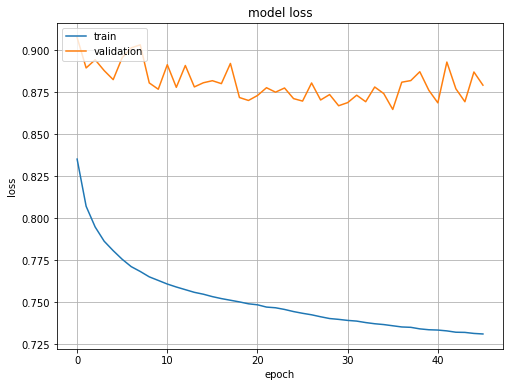

In [0]:
nn_model = build_nn_model(input_shape = [len(X_train.keys())])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
history = nn_model.fit(X_train, y_train, epochs = 1024, batch_size = 1024 * 2,
                    validation_data=(X_val, y_val), callbacks = [early_stop])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### Evaluate

In [0]:
evaluate_model(nn_model, X_train, y_train, X_val, y_val)

Training error; 0.85461646
Validation error: 0.9377255


### Save 

In [0]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_json = nn_model.to_json()
with open(model_path + "nn_model.json", "w") as json_file:
    json_file.write(model_json)
nn_model.save_weights("nn_model.h5")
print("Saved model to cloud")

## Light GBM

In [0]:
data = grid[base_features].reset_index(drop = True)

In [0]:
data = norm(data, all_cols = False)

In [0]:
for col in categorical_features:
     data.loc[:, col] = data[col].astype('category')

In [0]:
data.to_pickle(data_path + 'grid_custom.pkl')

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


### Training

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_shop_inter', 'item_category_id', 'month', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


it took:  83 seconds


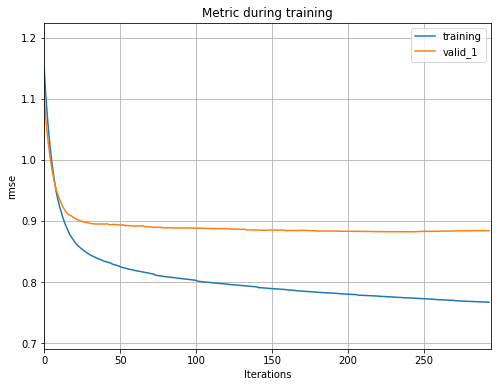

In [0]:
start = time.time()
params = {
  'metric': 'rmse',
  'objective': 'mse',
  'verbose': 0, 
  'learning_rate': 0.1,
  'num_leaves': 31,
  'min_data_in_leaf': 20 ,
  'max_depth': -1,
  'save_binary': True,
  'bagging_fraction': 0.8,
  'bagging_freq': 1,
  'bagging_seed': 2**7, 
  'feature_fraction': 0.8,
}
lgbm_model = create_model(X_train, y_train, X_val, y_val, params, categorical_features)
print('it took: ', round(time.time() - start), 'seconds')

### Evaluate

In [0]:
evaluate_model(lgbm_model, X_train, y_train, X_val, y_val)

Training error; 0.7737018925125985
Validation error: 0.8799753554607531


### Feature importance

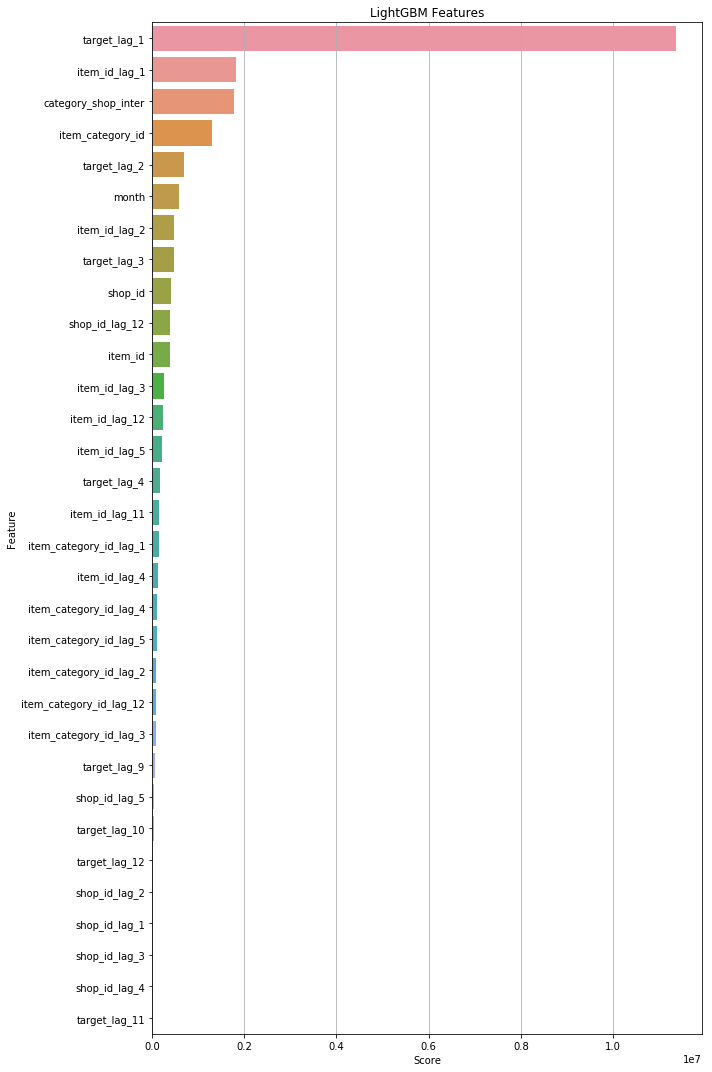

,Score,Feature
0,1.136368e+07,target_lag_1
1,1.816277e+06,item_id_lag_1
2,1.787349e+06,category_shop_inter
3,1.310092e+06,item_category_id
4,6.868096e+05,target_lag_2
5,5.812680e+05,month
6,4.690578e+05,item_id_lag_2
7,4.677951e+05,target_lag_3
8,4.174710e+05,shop_id
9,3.979536e+05,shop_id_lag_12


In [0]:
plot_feature_importance(lgbm_model, X_train)

### Save model

In [0]:
lgbm_model.save_model(model_path + 'lgbm_model.txt', num_iteration = lgbm_model.best_iteration)

## Catboost

In [0]:
data = grid[base_features].reset_index(drop = True)
data = norm(data, all_cols = False)

In [0]:
for col in categorical_features:
     data.loc[:, col] = data[col].astype('category')

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


In [0]:
categorical_features_index = []

for i, col in enumerate(X_train.columns):
    if X_train.loc[:, col].dtype.name == 'category':
        categorical_features_index.append(i)

### Training

In [0]:
start = time.time()
catboost_model = CatBoostRegressor(
    iterations = 4000,
    learning_rate = 0.1,
    max_depth = 10,
    od_type = 'Iter',
    od_wait = 20,
)
catboost_model.fit(
    X_train, y_train,
    eval_set = (X_val, y_val),
    cat_features = categorical_features_index
)
print('Model is fitted: ' + str(catboost_model.is_fitted()))
print('Model params:')
print(catboost_model.get_params())
print('it took: ', round(time.time() - start), 'seconds')

0:	learn: 1.1491383	test: 1.1045597	best: 1.1045597 (0)	total: 8.39s	remaining: 9h 19m 33s
1:	learn: 1.1100443	test: 1.0773494	best: 1.0773494 (1)	total: 16.8s	remaining: 9h 20m 17s
2:	learn: 1.0768462	test: 1.0542626	best: 1.0542626 (2)	total: 25.3s	remaining: 9h 21m 10s
3:	learn: 1.0489659	test: 1.0368493	best: 1.0368493 (3)	total: 33.1s	remaining: 9h 11m 11s
4:	learn: 1.0250040	test: 1.0213165	best: 1.0213165 (4)	total: 40.6s	remaining: 9h 1m 1s
5:	learn: 1.0041880	test: 1.0081057	best: 1.0081057 (5)	total: 48.4s	remaining: 8h 57m 11s
6:	learn: 0.9862839	test: 0.9956783	best: 0.9956783 (6)	total: 56.1s	remaining: 8h 53m 3s
7:	learn: 0.9714146	test: 0.9845038	best: 0.9845038 (7)	total: 1m 3s	remaining: 8h 49m 25s
8:	learn: 0.9584446	test: 0.9760210	best: 0.9760210 (8)	total: 1m 11s	remaining: 8h 48m 38s
9:	learn: 0.9475422	test: 0.9673411	best: 0.9673411 (9)	total: 1m 19s	remaining: 8h 48m 48s
10:	learn: 0.9385929	test: 0.9622132	best: 0.9622132 (10)	total: 1m 27s	remaining: 8h 47m 3

### Evaluate

In [0]:
evaluate_model(catboost_model, X_train, y_train, X_val, y_val)

Training error; 0.8203105844373765
Validation error: 0.8978499343909944


### Feature importance

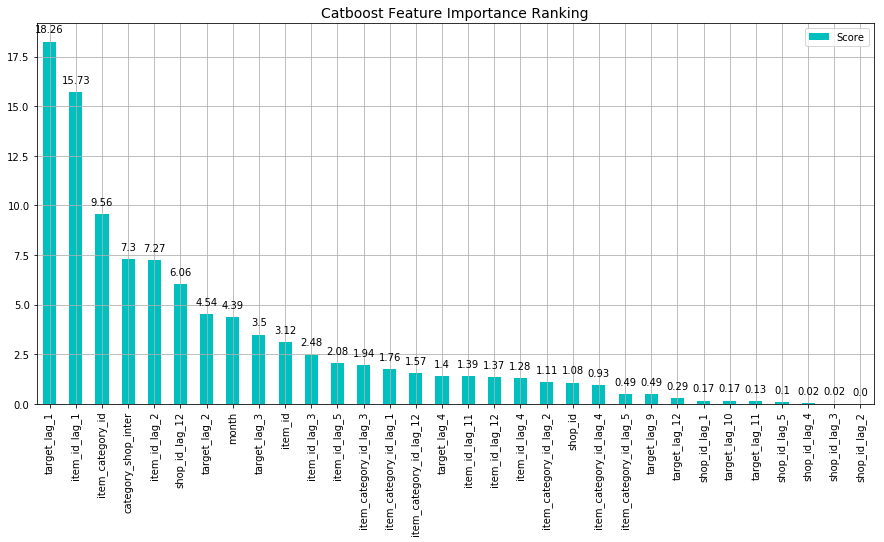

,Feature,Score
3,target_lag_1,18.259728
11,item_id_lag_1,15.733147
2,item_category_id,9.560714
31,category_shop_inter,7.297687
12,item_id_lag_2,7.265187
23,shop_id_lag_12,6.059813
4,target_lag_2,4.537710
30,month,4.394870
5,target_lag_3,3.495596
1,item_id,3.115046


In [0]:
plot_catboost_feature_importance(catboost_model, X_train, y_train)

### Save model

In [0]:
catboost_model.save_model(model_path + 'catboost_model.json', format = 'json')

## Xgboost

In [0]:
data = grid[base_features].reset_index(drop = True)
data = norm(data, all_cols = True)

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


### Training

In [0]:
start = time.time()
xgb_model = XGBRegressor(
    max_depth = 8,
    n_estimators = 50,
    min_child_weight = 0.5, 
    colsample_bytree = 0.9, 
    subsample = 0.8, 
    eta = 0.1,    
    seed = 1)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

print('it took: ', round(time.time() - start), 'seconds')

[10:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.1322	validation_1-rmse:1.12295
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.09285	validation_1-rmse:1.08913
[2]	validation_0-rmse:1.06466	validation_1-rmse:1.06564
[3]	validation_0-rmse:1.02396	validation_1-rmse:1.04273
[4]	validation_0-rmse:0.998133	validation_1-rmse:1.02466
[5]	validation_0-rmse:0.978824	validation_1-rmse:1.01014
[6]	validation_0-rmse:0.960831	validation_1-rmse:0.995959
[7]	validation_0-rmse:0.943559	validation_1-rmse:0.986499
[8]	validation_0-rmse:0.928078	validation_1-rms

### Evaluation

In [0]:
evaluate_model(xgb_model, X_train, y_train, X_val, y_val)

Training error; 0.82113296
Validation error: 0.9104165


### Feature importance

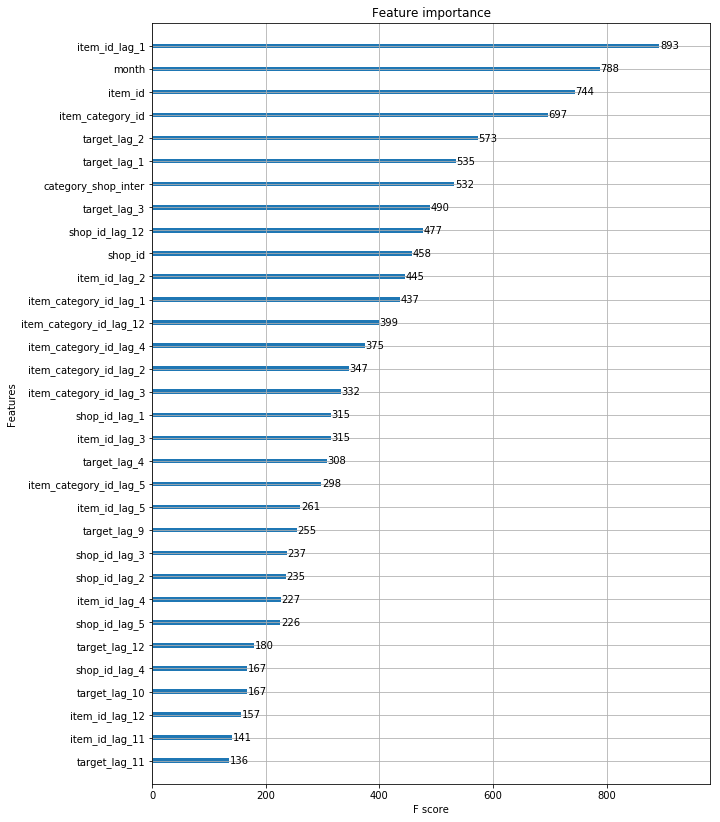

In [0]:
from xgboost import plot_importance
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)
plot_features(xgb_model, (10, 14))

### save model

In [0]:
joblib.dump(xgb_model, model_path + 'xgb_model.dat') 

['/content/drive/My Drive/Colab Notebooks/predict_future_sales/models/xgb_model.dat']

## Test meta-features

### Load base models if needed

In [ ]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open(model_path + 'nn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_path + "nn_model.h5")
print("Loaded model from cloud")

In [ ]:
from keras.models import load_model


lr_model = joblib.load(model_path + 'lr_model.dat')

lasso_model = joblib.load(model_path + 'lasso_model.dat')

catboost_model = CatBoostRegressor()
catboost_model.load_model(model_path + 'catboost_model.json', format = 'json')

lgbm_model = lgb.Booster(model_file = model_path + 'lgbm_model.txt')

xgb_model1 = joblib.load(model_path + 'xgb_model.dat')


### Generate test meta features

In [0]:
data = grid[base_features].reset_index(drop = True)
data = norm(data, all_cols = False)

In [0]:
for col in categorical_features:
    data.loc[:, col] = data[col].astype('category')

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


In [0]:
categorical_features_index = []

for i, col in enumerate(X_train.columns):
    if X_train.loc[:, col].dtype.name == 'category':
        categorical_features_index.append(i)

In [0]:
y_test_lgbm_hat = lgbm_model.predict(X_test)#.clip(0, 20)
y_test_catboost_hat = catboost_model.predict(X_test)#.clip(0, 20)

In [0]:
data = grid[base_features].reset_index(drop = True)
data = norm(data, all_cols = True)
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

Test `date_block_num` is 34
Validation `date_block_num` is 33
Train `date_block_num` is < 33
------------------------------
X_train shape:  (6115195, 32)
y_train shape:  (6115195,)
------------------------------
X_val shape:  (238172, 32)
y_val shape:  (238172,)
------------------------------
X_test shape:  (214200, 32)
y_test shape:  (214200,)
------------------------------


In [0]:
y_test_lr_hat = lr_model.predict(X_test)#.clip(0, 20)
y_test_lasso_hat = lasso_model.predict(X_test)#.clip(0, 20)
y_test_nn_hat = nn_model.predict(X_test)#.clip(0, 20)
y_test_xgb_hat = xgb_model.predict(X_test)#.clip(0, 20)

In [0]:
X_test_level2 = np.c_[y_test_lgbm_hat, y_test_catboost_hat, 
                      y_test_lr_hat, y_test_lasso_hat, y_test_nn_hat, y_test_xgb_hat ] 

In [0]:
np.savetxt(model_path + 'X_test_level2.csv', X_test_level2, delimiter = ",")

In [0]:
X_test_level2.shape

(214200, 6)

## Train / validation meta-features

In [0]:
data = grid[base_features].reset_index(drop = True)
data = norm(data, all_cols = True)

In [11]:
del grid
gc.collect()

322

In [180]:
dates = data['date_block_num']

months = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
y_train_level2 = data.loc[data['date_block_num'].isin(months)][['target']]
X_train_level2 = np.zeros([y_train_level2.shape[0], 6])
print(y_train_level2.shape)

(3733374, 1)


In [0]:
y_train_level2.to_pickle(model_path + 'y_train_level2.pkl')

In [0]:
lgbm_params = {
  'metric': 'rmse',
  'objective': 'mse',
  'verbose': 0, 
  'learning_rate': 0.1,
  'num_leaves': 31,
  'min_data_in_leaf': 20 ,
  'max_depth': -1,
  'save_binary': True,
  'bagging_fraction': 0.8,
  'bagging_freq': 1,
  'bagging_seed': 2**7, 
  'feature_fraction': 0.8,
}

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'max_depth': 10,
    'od_type': 'Iter',
    'od_wait':20,
}

xgboost_params = {
    'max_depth': 8,
    'n_estimators': 50,
    'min_child_weight': 0.5, 
    'colsample_bytree': 0.9, 
    'subsample': 0.8, 
    'eta': 0.1,    
    'seed': 1,
}

### Train base Models

In [19]:
start = time.time()
for cur_block_num in months:
    print('Start working on month: --->> ', cur_block_num)

    X_train_l1 = data.loc[dates < cur_block_num - 1].drop(cols_to_drop, axis = 1)
    y_train_l1 = data.loc[dates < cur_block_num - 1, 'target'].values

    X_val_l1 = data.loc[dates == cur_block_num - 1].drop(cols_to_drop, axis = 1)
    y_val_l1 = data.loc[dates == cur_block_num - 1, 'target'].values

    X_test_l1 = data.loc[dates ==  cur_block_num].drop(cols_to_drop, axis = 1)
      
    # LightGBM
    d_train = lgb.Dataset(X_train_l1, label = y_train_l1)
    d_valid = lgb.Dataset(X_val_l1, label = y_val_l1)
    watchlist = [d_train, d_valid]
    lgbm_bmodel = lgb.train(lgbm_params, 
                          d_train, 
                          2000, 
                          valid_sets = watchlist, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 0,)
    y_lgbm = lgbm_bmodel.predict(X_test_l1)#.clip(0, 20)
    
    # Catboost
    catboost_bmodel = CatBoostRegressor(**catboost_params)
    catboost_bmodel.fit(
        X_train_l1, 
        y_train_l1, 
        eval_set = (X_val_l1, y_val_l1), 
        verbose = False, )
    y_catboost = catboost_bmodel.predict(X_test_l1)#..clip(0, 20)

    
    # Linear Regression
    lr_bmodel = LinearRegression(normalize = True)
    lr_bmodel.fit(X_train_l1.values, y_train_l1)
    y_lr = lr_bmodel.predict(X_test_l1.values)

    # Lasso Regression
    lasso_bmodel = linear_model.Lasso(alpha = 0.01)
    lasso_bmodel.fit(X_train_l1.values, y_train_l1)
    y_lasso = lasso_bmodel.predict(X_test_l1.values)

    # Neural Network
    nn_bmodel = build_nn_model(input_shape = [len(X_train_l1.keys())])
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = nn_bmodel.fit(X_train_l1, y_train_l1, epochs = 1024, batch_size = 1024 * 2,
                    validation_data=(X_val_l1, y_val_l1), callbacks = [early_stop], verbose = 0)
    y_nn = nn_bmodel.predict(X_test_l1.values)
    
    # Xgboost
    xgb_bmodel = XGBRegressor(**xgboost_params)
    xgb_bmodel.fit(
        X_train_l1, 
        y_train_l1, 
        eval_metric = "rmse", 
        eval_set = [(X_train_l1, y_train_l1), (X_val_l1, y_val_l1)], 
        verbose = False, 
        early_stopping_rounds = 10)
    y_xgboost = xgb_bmodel.predict(X_test_l1)

    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[y_lgbm, y_catboost, 
                                                                y_lr, y_lasso, y_nn, y_xgboost ]
    print('End working on month: --->> ', cur_block_num)

print('it took: ', round(time.time() - start), 'seconds')

Start working on month: --->>  20
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[08:09:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
End working on month: --->>  20
Start working on month: --->>  21
[08:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
End working on month: --->>  21
Start working on month: --->>  22
[08:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
End working on month: --->>  22
Start working on month: --->>  23
[08:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
End working on month: --->>  23
Start working on month: --->>  24
[09:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:line

In [0]:
np.savetxt(model_path + 'X_train_level2.csv', X_train_level2, delimiter = ",")

## Stacking

### Load data if needed

In [0]:
cols = ['lgbm', 'catboost', 'lr', 'lasso','network', 'xgboost']

In [0]:
X_test_level2 = pd.read_csv(model_path + 'X_test_level2.csv', header = None)
X_test_level2.columns = cols

In [0]:
y_train_level2 = pd.read_pickle(model_path + 'y_train_level2.pkl')
y_train_level2 = y_train_level2.reset_index(drop = True)

In [0]:
X_train_level2 = pd.read_csv(model_path + 'X_train_level2.csv', header = None, )
X_train_level2.columns = cols
dates_train_level2 = pd.read_pickle(model_path + 'dates_train_level2.pkl')
dates_train_level2 = dates_train_level2.reset_index(drop = True)

In [0]:
subcols = ['lgbm',	'catboost', 'xgboost']

In [0]:
X_train_level2 = X_train_level2[subcols]
X_test_level2 = X_test_level2[subcols]

### Build meta model

I will try Linear Regression, lightGBM and Averaging as meta model. I will train them on the meta training features and validate them using the meta validation features. Then compare the error on the validation set and pick the best.

In [0]:
last_month = dates_train_level2.max()
X_train_meta = X_train_level2[dates_train_level2 < last_month]
y_train_meta = y_train_level2[dates_train_level2 < last_month]

X_val_meta = X_train_level2[dates_train_level2 == last_month]
y_val_meta = y_train_level2[dates_train_level2 == last_month]

#### LR

In [301]:
lr_meta_model = LinearRegression(normalize=True)
lr_meta_model.fit(X_train_meta, y_train_meta)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [302]:
print('rmse on meta train: ', rmse(lr_meta_model.predict(X_train_meta).clip(0, 20), y_train_meta))
print('rmse on meta validation: ', rmse(lr_meta_model.predict(X_val_meta).clip(0, 20), y_val_meta))

rmse on meta train:  0.9098333097134329
rmse on meta validation:  0.9054708888343179


#### Light GBM

[1]	training's rmse: 1.19982	valid_1's rmse: 1.12482
Training until validation scores don't improve for 150 rounds.
[2]	training's rmse: 1.18552	valid_1's rmse: 1.11348
[3]	training's rmse: 1.1719	valid_1's rmse: 1.10273
[4]	training's rmse: 1.15894	valid_1's rmse: 1.09261
[5]	training's rmse: 1.14661	valid_1's rmse: 1.08297
[6]	training's rmse: 1.13487	valid_1's rmse: 1.07386
[7]	training's rmse: 1.12371	valid_1's rmse: 1.06521
[8]	training's rmse: 1.1131	valid_1's rmse: 1.05705
[9]	training's rmse: 1.10303	valid_1's rmse: 1.04929
[10]	training's rmse: 1.09347	valid_1's rmse: 1.04202
[11]	training's rmse: 1.08438	valid_1's rmse: 1.03512
[12]	training's rmse: 1.07576	valid_1's rmse: 1.02859
[13]	training's rmse: 1.06757	valid_1's rmse: 1.02242
[14]	training's rmse: 1.05982	valid_1's rmse: 1.01658
[15]	training's rmse: 1.05246	valid_1's rmse: 1.01112
[16]	training's rmse: 1.04549	valid_1's rmse: 1.00596
[17]	training's rmse: 1.0389	valid_1's rmse: 1.00111
[18]	training's rmse: 1.03264	v

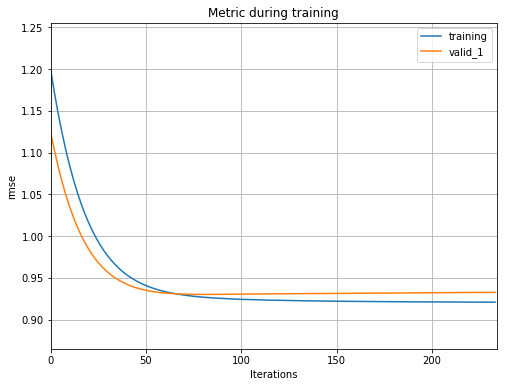

In [304]:
start = time.time()
n_estimators = 1000
params = {
    'max_depth': -1,
    'metric': 'rmse',
    'nthread': 1, 
    'learning_rate': 0.03, 
    'objective': 'mse',
    'verbose': 1,
}
d_train = lgb.Dataset(X_train_meta, y_train_meta)
d_valid = lgb.Dataset(X_val_meta, y_val_meta)
watchlist = [d_train, d_valid]
evals_result = {}
lgbm_meta_model = lgb.train(params, 
                      d_train, 
                      n_estimators,
                      valid_sets = watchlist, 
                      evals_result = evals_result, 
                      early_stopping_rounds = 150,
                      verbose_eval = 1,
                    )
print('it took: ', round(time.time() - start), 'seconds')
lgb.plot_metric(evals_result)

In [305]:
print('rmse on meta train: ', rmse(lgbm_meta_model.predict(X_train_meta).clip(0, 20), y_train_meta))
print('rmse on meta validation: ', rmse(lgbm_meta_model.predict(X_val_meta).clip(0, 20), y_val_meta))

rmse on meta train:  0.9263038449757224
rmse on meta validation:  0.9301483887918832


### Averaging

In [0]:
train_pred = X_train_meta.mean(axis = 1).clip(0, 20)
val_pred = X_val_meta.mean(axis = 1).clip(0, 20)
test_preds =  X_test_level2.mean(axis = 1).clip(0, 20)

In [308]:
print('rmse on meta train: ', rmse(train_pred, y_train_meta))
print('rmse on meta validation: ', rmse(val_pred, y_val_meta))

rmse on meta train:  0.9104895293233637
rmse on meta validation:  0.9047025935649906


# Submit

In [311]:
submission, submission_name = create_submission(lr_meta_model, X_test_level2, 'lr_meta_model')

saved:  /content/drive/My Drive/Colab Notebooks/predict_future_sales/submissions/lr_meta_model_18_31_58__20_Sep_2019.csv


In [312]:
submit_solution(submission, submission_name, True)

100% 5.08M/5.08M [00:01<00:00, 3.51MB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (7.5 hours from now).
